In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
!pip install keras-tuner

You should consider upgrading via the '/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/bin/python -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [5]:
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

<IPython.core.display.Javascript object>

In [6]:
setup_seed()

<IPython.core.display.Javascript object>

In [7]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [8]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Census income : loading data

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

dataset_name = "census-income"
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")
out_test = Path(os.getcwd() + "/data/" + dataset_name + "_test.csv")

download(url, out, force=False)
download(url_test, out_test, force=False)

File already exists.
File already exists.


<IPython.core.display.Javascript object>

In [10]:
cols = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "target",
]

<IPython.core.display.Javascript object>

In [11]:
train = pd.read_csv(out, names=cols)
test = pd.read_csv(out_test, names=cols, skiprows=2)
target = "target"

train[target] = train[target].str.strip()
# Test has . in label, let's clean it
test[target] = test[target].str.strip().str.strip(".")

<IPython.core.display.Javascript object>

In [12]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>

In [13]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
# test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [14]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['sex'],
 'num_cols': ['fnlwgt'],
 'cat_cols': ['hours-per-week',
  'education-num',
  'native-country',
  'marital-status',
  'workclass',
  'capital-gain',
  'education',
  'relationship',
  'age',
  'occupation',
  'capital-loss',
  'race'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=1740.018844394761,
                                                                 strategy='constant')),
                                                  ('scaler',
                                                   StandardScaler())]))])],
 'bool_encoder': [SafeLabelEncoder()],
 'max_nb': 117,
 'cat_encoder': [SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabel

<IPython.core.display.Javascript object>

In [15]:
len(train_indices)

29304

<IPython.core.display.Javascript object>

In [16]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(test, target, ["Set"], params)

<IPython.core.display.Javascript object>

In [17]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [18]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = target_encoder.fit_transform(test[target].values)

<IPython.core.display.Javascript object>

In [19]:
params

{'constant_cols': [],
 'bool_cols': ['sex'],
 'num_cols': ['fnlwgt'],
 'cat_cols': ['hours-per-week',
  'education-num',
  'native-country',
  'marital-status',
  'workclass',
  'capital-gain',
  'education',
  'relationship',
  'age',
  'occupation',
  'capital-loss',
  'race'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=1740.018844394761,
                                                                 strategy='constant')),
                                                  ('scaler',
                                                   StandardScaler())]))])],
 'bool_encoder': [SafeLabelEncoder()],
 'max_nb': 117,
 'cat_encoder': [SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabelEncoder(),
  SafeLabel

<IPython.core.display.Javascript object>

In [20]:
def build_model_tuner_builder(params):
    def build_model_tuner(hp):
        lconv_dim_list = []
        emb_size = 4
        if len(params["cat_cols"]) > 0:
            for i in range(hp.Int("num_layers_cat", 0, 3, default=1)):
                dim = hp.Int("units_cat_" + str(i), 1, 5, 1, default=2)
                lconv_dim_list.append(int(2 ** dim))
            emb_size = hp.Int("emb_size", 1, 8, 1, default=4)

        lconv_num_dim_list = []
        activation_num_first_layer = None
        if len(params["num_cols"]) > 0:
            for i in range(hp.Int("num_layers_num", 0, 3, default=1)):
                dim = hp.Int("units_num_" + str(i), 1, 6, 1, default=3)
                lconv_num_dim_list.append(int(2 ** dim))
            activation_num_first_layer = hp.Choice(
                "activation_num_first_layer", ["None", "tanh"], default="None"
            )
            if activation_num_first_layer == "None":
                activation_num_first_layer = None

        output_activation = hp.Choice(
            "output_activation", ["sigmoid", "softmax"], default="sigmoid"
        )
        output_dim = 1 if output_activation == "sigmoid" else 2
        emb_size = int(2 ** emb_size)

        return build_model(
            params,
            lconv_dim=lconv_dim_list,
            lconv_num_dim=lconv_num_dim_list,
            emb_size=emb_size,
            activation_num_first_layer=activation_num_first_layer,  # "tanh",
            output_dim=output_dim,
            output_activation=output_activation,
        )

    return build_model_tuner

<IPython.core.display.Javascript object>

In [21]:
import shutil

shutil.rmtree("test_dir", ignore_errors=True)

<IPython.core.display.Javascript object>

In [22]:
tuner = RandomSearch(
    build_model_tuner_builder(params),
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    directory="test_dir",
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [23]:
tuner.search_space_summary()

<IPython.core.display.Javascript object>

In [24]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [25]:
class_weight = {
    0: counts[0],
    1: counts[1],
}
class_weight

{0: 1.3172113093900302, 1: 4.152472722119881}

<IPython.core.display.Javascript object>

In [26]:
tuner.search(
    input_train,
    y_train.reshape(-1, 1),
    epochs=50,
    batch_size=1024,
    validation_data=(
        input_valid,
        y_valid.reshape(-1, 1),
    ),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=1, verbose=1)],
    class_weight=class_weight,
)

Epoch 1/50
29/29 - 0s - loss: 1.3858 - val_loss: 0.7074
Epoch 2/50
29/29 - 0s - loss: 1.3853 - val_loss: 0.7069
Epoch 3/50
29/29 - 0s - loss: 1.3846 - val_loss: 0.7064
Epoch 4/50
29/29 - 0s - loss: 1.3837 - val_loss: 0.7058
Epoch 5/50
29/29 - 0s - loss: 1.3828 - val_loss: 0.7051
Epoch 6/50
29/29 - 0s - loss: 1.3816 - val_loss: 0.7044
Epoch 7/50
29/29 - 0s - loss: 1.3802 - val_loss: 0.7031
Epoch 8/50
29/29 - 0s - loss: 1.3783 - val_loss: 0.7015
Epoch 9/50
29/29 - 0s - loss: 1.3752 - val_loss: 0.6990
Epoch 10/50
29/29 - 0s - loss: 1.3701 - val_loss: 0.6953
Epoch 11/50
29/29 - 0s - loss: 1.3613 - val_loss: 0.6892
Epoch 12/50
29/29 - 0s - loss: 1.3464 - val_loss: 0.6793
Epoch 13/50
29/29 - 0s - loss: 1.3221 - val_loss: 0.6601
Epoch 14/50
29/29 - 0s - loss: 1.2844 - val_loss: 0.6368
Epoch 15/50
29/29 - 0s - loss: 1.2309 - val_loss: 0.6067
Epoch 16/50
29/29 - 0s - loss: 1.1629 - val_loss: 0.5709
Epoch 17/50
29/29 - 0s - loss: 1.0874 - val_loss: 0.5339
Epoch 18/50
29/29 - 0s - loss: 1.0160 - 

Epoch 1/50
29/29 - 0s - loss: 1.3929 - val_loss: 0.6878
Epoch 2/50
29/29 - 0s - loss: 1.3913 - val_loss: 0.6873
Epoch 3/50
29/29 - 0s - loss: 1.3888 - val_loss: 0.6864
Epoch 4/50
29/29 - 0s - loss: 1.3853 - val_loss: 0.6851
Epoch 5/50
29/29 - 0s - loss: 1.3804 - val_loss: 0.6830
Epoch 6/50
29/29 - 0s - loss: 1.3731 - val_loss: 0.6794
Epoch 7/50
29/29 - 0s - loss: 1.3622 - val_loss: 0.6723
Epoch 8/50
29/29 - 0s - loss: 1.3460 - val_loss: 0.6627
Epoch 9/50
29/29 - 0s - loss: 1.3221 - val_loss: 0.6486
Epoch 10/50
29/29 - 0s - loss: 1.2884 - val_loss: 0.6303
Epoch 11/50
29/29 - 0s - loss: 1.2435 - val_loss: 0.6061
Epoch 12/50
29/29 - 0s - loss: 1.1882 - val_loss: 0.5769
Epoch 13/50
29/29 - 0s - loss: 1.1263 - val_loss: 0.5385
Epoch 14/50
29/29 - 0s - loss: 1.0627 - val_loss: 0.5088
Epoch 15/50
29/29 - 0s - loss: 1.0041 - val_loss: 0.4823
Epoch 16/50
29/29 - 0s - loss: 0.9551 - val_loss: 0.4604
Epoch 17/50
29/29 - 0s - loss: 0.9167 - val_loss: 0.4440
Epoch 18/50
29/29 - 0s - loss: 0.8879 - 

Epoch 1/50
29/29 - 0s - loss: 1.3744 - val_loss: 0.7300
Epoch 2/50
29/29 - 0s - loss: 1.3718 - val_loss: 0.7263
Epoch 3/50
29/29 - 0s - loss: 1.3677 - val_loss: 0.7215
Epoch 4/50
29/29 - 0s - loss: 1.3623 - val_loss: 0.7154
Epoch 5/50
29/29 - 0s - loss: 1.3549 - val_loss: 0.7076
Epoch 6/50
29/29 - 0s - loss: 1.3444 - val_loss: 0.6971
Epoch 7/50
29/29 - 0s - loss: 1.3296 - val_loss: 0.6796
Epoch 8/50
29/29 - 0s - loss: 1.3085 - val_loss: 0.6604
Epoch 9/50
29/29 - 0s - loss: 1.2795 - val_loss: 0.6370
Epoch 10/50
29/29 - 0s - loss: 1.2413 - val_loss: 0.6107
Epoch 11/50
29/29 - 0s - loss: 1.1938 - val_loss: 0.5820
Epoch 12/50
29/29 - 0s - loss: 1.1388 - val_loss: 0.5522
Epoch 13/50
29/29 - 0s - loss: 1.0805 - val_loss: 0.5179
Epoch 14/50
29/29 - 0s - loss: 1.0234 - val_loss: 0.4926
Epoch 15/50
29/29 - 0s - loss: 0.9728 - val_loss: 0.4703
Epoch 16/50
29/29 - 0s - loss: 0.9312 - val_loss: 0.4517
Epoch 17/50
29/29 - 0s - loss: 0.8986 - val_loss: 0.4375
Epoch 18/50
29/29 - 0s - loss: 0.8735 - 

Epoch 1/50
29/29 - 0s - loss: 1.3700 - val_loss: 0.7061
Epoch 2/50
29/29 - 0s - loss: 1.3673 - val_loss: 0.7037
Epoch 3/50
29/29 - 0s - loss: 1.3633 - val_loss: 0.7008
Epoch 4/50
29/29 - 0s - loss: 1.3583 - val_loss: 0.6974
Epoch 5/50
29/29 - 0s - loss: 1.3523 - val_loss: 0.6936
Epoch 6/50
29/29 - 0s - loss: 1.3453 - val_loss: 0.6892
Epoch 7/50
29/29 - 0s - loss: 1.3372 - val_loss: 0.6829
Epoch 8/50
29/29 - 0s - loss: 1.3277 - val_loss: 0.6768
Epoch 9/50
29/29 - 0s - loss: 1.3167 - val_loss: 0.6698
Epoch 10/50
29/29 - 0s - loss: 1.3042 - val_loss: 0.6624
Epoch 11/50
29/29 - 0s - loss: 1.2899 - val_loss: 0.6540
Epoch 12/50
29/29 - 0s - loss: 1.2738 - val_loss: 0.6445
Epoch 13/50
29/29 - 0s - loss: 1.2560 - val_loss: 0.6318
Epoch 14/50
29/29 - 0s - loss: 1.2363 - val_loss: 0.6204
Epoch 15/50
29/29 - 0s - loss: 1.2150 - val_loss: 0.6088
Epoch 16/50
29/29 - 0s - loss: 1.1925 - val_loss: 0.5965
Epoch 17/50
29/29 - 0s - loss: 1.1690 - val_loss: 0.5838
Epoch 18/50
29/29 - 0s - loss: 1.1449 - 

Epoch 1/50
29/29 - 0s - loss: 1.3914 - val_loss: 0.6861
Epoch 2/50
29/29 - 0s - loss: 1.3911 - val_loss: 0.6866
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3776 - val_loss: 0.7228
Epoch 2/50
29/29 - 0s - loss: 1.3745 - val_loss: 0.7188
Epoch 3/50
29/29 - 0s - loss: 1.3697 - val_loss: 0.7136
Epoch 4/50
29/29 - 0s - loss: 1.3631 - val_loss: 0.7068
Epoch 5/50
29/29 - 0s - loss: 1.3535 - val_loss: 0.6978
Epoch 6/50
29/29 - 0s - loss: 1.3393 - val_loss: 0.6851
Epoch 7/50
29/29 - 0s - loss: 1.3180 - val_loss: 0.6631
Epoch 8/50
29/29 - 0s - loss: 1.2864 - val_loss: 0.6383
Epoch 9/50
29/29 - 0s - loss: 1.2421 - val_loss: 0.6079
Epoch 10/50
29/29 - 0s - loss: 1.1847 - val_loss: 0.5746
Epoch 11/50
29/29 - 0s - loss: 1.1178 - val_loss: 0.5393
Epoch 12/50
29/29 - 0s - loss: 1.0489 - val_loss: 0.5056
Epoch 13/50
29/29 - 0s - loss: 0.9867 - val_loss: 0.4709
Epoch 14/50
29/29 - 0s - loss: 0.9357 - val_loss: 0.4498
Epoch 15/50
29/29 - 0s - loss: 0.8972 - val_loss: 0.4310
Epoch 16/50
29/29 - 0s - loss: 0.8687 - val_loss: 0.4183
Epoch 17/50
29/29 - 0s - loss: 0.8470 - val_loss: 0.4092
Epoch 18/50
29/29 - 0s - loss: 0.8295 - 

Epoch 1/50
29/29 - 0s - loss: 1.4032 - val_loss: 0.6891
Epoch 2/50
29/29 - 0s - loss: 1.4020 - val_loss: 0.6891
Epoch 00002: early stopping


Epoch 1/50
29/29 - 1s - loss: 1.3857 - val_loss: 0.6915
Epoch 2/50
29/29 - 0s - loss: 1.3854 - val_loss: 0.6916
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.4124 - val_loss: 0.6844
Epoch 2/50
29/29 - 0s - loss: 1.4089 - val_loss: 0.6838
Epoch 3/50
29/29 - 0s - loss: 1.4037 - val_loss: 0.6828
Epoch 4/50
29/29 - 0s - loss: 1.3973 - val_loss: 0.6815
Epoch 5/50
29/29 - 0s - loss: 1.3899 - val_loss: 0.6798
Epoch 6/50
29/29 - 0s - loss: 1.3814 - val_loss: 0.6774
Epoch 7/50
29/29 - 0s - loss: 1.3717 - val_loss: 0.6735
Epoch 8/50
29/29 - 0s - loss: 1.3606 - val_loss: 0.6693
Epoch 9/50
29/29 - 0s - loss: 1.3480 - val_loss: 0.6638
Epoch 10/50
29/29 - 0s - loss: 1.3337 - val_loss: 0.6580
Epoch 11/50
29/29 - 0s - loss: 1.3175 - val_loss: 0.6509
Epoch 12/50
29/29 - 0s - loss: 1.2995 - val_loss: 0.6425
Epoch 13/50
29/29 - 0s - loss: 1.2798 - val_loss: 0.6309
Epoch 14/50
29/29 - 0s - loss: 1.2581 - val_loss: 0.6204
Epoch 15/50
29/29 - 0s - loss: 1.2349 - val_loss: 0.6095
Epoch 16/50
29/29 - 0s - loss: 1.2105 - val_loss: 0.5976
Epoch 17/50
29/29 - 0s - loss: 1.1853 - val_loss: 0.5852
Epoch 18/50
29/29 - 0s - loss: 1.1596 - 

Epoch 1/50
29/29 - 0s - loss: 1.4144 - val_loss: 0.6664
Epoch 2/50
29/29 - 0s - loss: 1.4114 - val_loss: 0.6664
Epoch 3/50
29/29 - 0s - loss: 1.4071 - val_loss: 0.6662
Epoch 4/50
29/29 - 0s - loss: 1.4017 - val_loss: 0.6659
Epoch 5/50
29/29 - 0s - loss: 1.3954 - val_loss: 0.6654
Epoch 6/50
29/29 - 0s - loss: 1.3882 - val_loss: 0.6646
Epoch 7/50
29/29 - 0s - loss: 1.3802 - val_loss: 0.6631
Epoch 8/50
29/29 - 0s - loss: 1.3712 - val_loss: 0.6612
Epoch 9/50
29/29 - 0s - loss: 1.3613 - val_loss: 0.6586
Epoch 10/50
29/29 - 0s - loss: 1.3503 - val_loss: 0.6558
Epoch 11/50
29/29 - 0s - loss: 1.3383 - val_loss: 0.6522
Epoch 12/50
29/29 - 0s - loss: 1.3253 - val_loss: 0.6478
Epoch 13/50
29/29 - 0s - loss: 1.3113 - val_loss: 0.6414
Epoch 14/50
29/29 - 0s - loss: 1.2962 - val_loss: 0.6352
Epoch 15/50
29/29 - 0s - loss: 1.2801 - val_loss: 0.6286
Epoch 16/50
29/29 - 0s - loss: 1.2632 - val_loss: 0.6211
Epoch 17/50
29/29 - 0s - loss: 1.2455 - val_loss: 0.6130
Epoch 18/50
29/29 - 0s - loss: 1.2272 - 

Epoch 1/50
29/29 - 0s - loss: 1.4053 - val_loss: 0.6825
Epoch 2/50
29/29 - 0s - loss: 1.4045 - val_loss: 0.6829
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3849 - val_loss: 0.6878
Epoch 2/50
29/29 - 0s - loss: 1.3840 - val_loss: 0.6877
Epoch 3/50
29/29 - 0s - loss: 1.3826 - val_loss: 0.6874
Epoch 4/50
29/29 - 0s - loss: 1.3803 - val_loss: 0.6867
Epoch 5/50
29/29 - 0s - loss: 1.3767 - val_loss: 0.6850
Epoch 6/50
29/29 - 0s - loss: 1.3701 - val_loss: 0.6812
Epoch 7/50
29/29 - 0s - loss: 1.3579 - val_loss: 0.6712
Epoch 8/50
29/29 - 0s - loss: 1.3357 - val_loss: 0.6551
Epoch 9/50
29/29 - 0s - loss: 1.2973 - val_loss: 0.6296
Epoch 10/50
29/29 - 0s - loss: 1.2375 - val_loss: 0.5946
Epoch 11/50
29/29 - 0s - loss: 1.1567 - val_loss: 0.5515
Epoch 12/50
29/29 - 0s - loss: 1.0656 - val_loss: 0.5070
Epoch 13/50
29/29 - 0s - loss: 0.9824 - val_loss: 0.4622
Epoch 14/50
29/29 - 0s - loss: 0.9190 - val_loss: 0.4382
Epoch 15/50
29/29 - 0s - loss: 0.8766 - val_loss: 0.4176
Epoch 16/50
29/29 - 0s - loss: 0.8480 - val_loss: 0.4056
Epoch 17/50
29/29 - 0s - loss: 0.8270 - val_loss: 0.3996
Epoch 18/50
29/29 - 0s - loss: 0.8106 - 

Epoch 1/50
29/29 - 0s - loss: 1.3782 - val_loss: 0.7049
Epoch 2/50
29/29 - 0s - loss: 1.3779 - val_loss: 0.7044
Epoch 3/50
29/29 - 0s - loss: 1.3774 - val_loss: 0.7038
Epoch 4/50
29/29 - 0s - loss: 1.3767 - val_loss: 0.7031
Epoch 5/50
29/29 - 0s - loss: 1.3759 - val_loss: 0.7023
Epoch 6/50
29/29 - 0s - loss: 1.3747 - val_loss: 0.7012
Epoch 7/50
29/29 - 0s - loss: 1.3731 - val_loss: 0.6994
Epoch 8/50
29/29 - 0s - loss: 1.3707 - val_loss: 0.6974
Epoch 9/50
29/29 - 0s - loss: 1.3671 - val_loss: 0.6943
Epoch 10/50
29/29 - 0s - loss: 1.3617 - val_loss: 0.6904
Epoch 11/50
29/29 - 0s - loss: 1.3535 - val_loss: 0.6846
Epoch 12/50
29/29 - 0s - loss: 1.3416 - val_loss: 0.6765
Epoch 13/50
29/29 - 0s - loss: 1.3243 - val_loss: 0.6622
Epoch 14/50
29/29 - 0s - loss: 1.3000 - val_loss: 0.6459
Epoch 15/50
29/29 - 0s - loss: 1.2672 - val_loss: 0.6255
Epoch 16/50
29/29 - 0s - loss: 1.2255 - val_loss: 0.6007
Epoch 17/50
29/29 - 0s - loss: 1.1755 - val_loss: 0.5727
Epoch 18/50
29/29 - 0s - loss: 1.1199 - 

Epoch 1/50
29/29 - 0s - loss: 1.3752 - val_loss: 0.7007
Epoch 2/50
29/29 - 0s - loss: 1.3693 - val_loss: 0.6942
Epoch 3/50
29/29 - 0s - loss: 1.3595 - val_loss: 0.6849
Epoch 4/50
29/29 - 0s - loss: 1.3437 - val_loss: 0.6715
Epoch 5/50
29/29 - 0s - loss: 1.3175 - val_loss: 0.6517
Epoch 6/50
29/29 - 0s - loss: 1.2745 - val_loss: 0.6225
Epoch 7/50
29/29 - 0s - loss: 1.2098 - val_loss: 0.5750
Epoch 8/50
29/29 - 0s - loss: 1.1250 - val_loss: 0.5295
Epoch 9/50
29/29 - 0s - loss: 1.0344 - val_loss: 0.4915
Epoch 10/50
29/29 - 0s - loss: 0.9570 - val_loss: 0.4583
Epoch 11/50
29/29 - 0s - loss: 0.9014 - val_loss: 0.4337
Epoch 12/50
29/29 - 0s - loss: 0.8639 - val_loss: 0.4170
Epoch 13/50
29/29 - 0s - loss: 0.8373 - val_loss: 0.3996
Epoch 14/50
29/29 - 0s - loss: 0.8167 - val_loss: 0.3919
Epoch 15/50
29/29 - 0s - loss: 0.8004 - val_loss: 0.3818
Epoch 16/50
29/29 - 0s - loss: 0.7870 - val_loss: 0.3771
Epoch 17/50
29/29 - 0s - loss: 0.7761 - val_loss: 0.3779
Epoch 00017: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3720 - val_loss: 0.7145
Epoch 2/50
29/29 - 0s - loss: 1.3714 - val_loss: 0.7137
Epoch 3/50
29/29 - 0s - loss: 1.3704 - val_loss: 0.7125
Epoch 4/50
29/29 - 0s - loss: 1.3691 - val_loss: 0.7112
Epoch 5/50
29/29 - 0s - loss: 1.3672 - val_loss: 0.7096
Epoch 6/50
29/29 - 0s - loss: 1.3648 - val_loss: 0.7075
Epoch 7/50
29/29 - 0s - loss: 1.3612 - val_loss: 0.7040
Epoch 8/50
29/29 - 0s - loss: 1.3562 - val_loss: 0.6998
Epoch 9/50
29/29 - 0s - loss: 1.3491 - val_loss: 0.6941
Epoch 10/50
29/29 - 0s - loss: 1.3391 - val_loss: 0.6867
Epoch 11/50
29/29 - 0s - loss: 1.3255 - val_loss: 0.6768
Epoch 12/50
29/29 - 0s - loss: 1.3072 - val_loss: 0.6638
Epoch 13/50
29/29 - 0s - loss: 1.2838 - val_loss: 0.6438
Epoch 14/50
29/29 - 0s - loss: 1.2547 - val_loss: 0.6242
Epoch 15/50
29/29 - 0s - loss: 1.2203 - val_loss: 0.6030
Epoch 16/50
29/29 - 0s - loss: 1.1815 - val_loss: 0.5803
Epoch 17/50
29/29 - 0s - loss: 1.1398 - val_loss: 0.5578
Epoch 18/50
29/29 - 0s - loss: 1.0971 - 

Epoch 1/50
29/29 - 0s - loss: 1.3934 - val_loss: 0.6994
Epoch 2/50
29/29 - 0s - loss: 1.3919 - val_loss: 0.6984
Epoch 3/50
29/29 - 0s - loss: 1.3898 - val_loss: 0.6971
Epoch 4/50
29/29 - 0s - loss: 1.3871 - val_loss: 0.6954
Epoch 5/50
29/29 - 0s - loss: 1.3835 - val_loss: 0.6929
Epoch 6/50
29/29 - 0s - loss: 1.3775 - val_loss: 0.6886
Epoch 7/50
29/29 - 0s - loss: 1.3668 - val_loss: 0.6784
Epoch 8/50
29/29 - 0s - loss: 1.3468 - val_loss: 0.6627
Epoch 9/50
29/29 - 0s - loss: 1.3109 - val_loss: 0.6376
Epoch 10/50
29/29 - 0s - loss: 1.2527 - val_loss: 0.6028
Epoch 11/50
29/29 - 0s - loss: 1.1718 - val_loss: 0.5598
Epoch 12/50
29/29 - 0s - loss: 1.0796 - val_loss: 0.5152
Epoch 13/50
29/29 - 0s - loss: 0.9957 - val_loss: 0.4695
Epoch 14/50
29/29 - 0s - loss: 0.9322 - val_loss: 0.4454
Epoch 15/50
29/29 - 0s - loss: 0.8905 - val_loss: 0.4256
Epoch 16/50
29/29 - 0s - loss: 0.8630 - val_loss: 0.4143
Epoch 17/50
29/29 - 0s - loss: 0.8431 - val_loss: 0.4078
Epoch 18/50
29/29 - 0s - loss: 0.8273 - 

Epoch 1/50
29/29 - 0s - loss: 1.3997 - val_loss: 0.6931
Epoch 2/50
29/29 - 0s - loss: 1.3959 - val_loss: 0.6913
Epoch 3/50
29/29 - 0s - loss: 1.3899 - val_loss: 0.6886
Epoch 4/50
29/29 - 0s - loss: 1.3816 - val_loss: 0.6848
Epoch 5/50
29/29 - 0s - loss: 1.3698 - val_loss: 0.6792
Epoch 6/50
29/29 - 0s - loss: 1.3521 - val_loss: 0.6699
Epoch 7/50
29/29 - 0s - loss: 1.3259 - val_loss: 0.6519
Epoch 8/50
29/29 - 0s - loss: 1.2878 - val_loss: 0.6292
Epoch 9/50
29/29 - 0s - loss: 1.2357 - val_loss: 0.5999
Epoch 10/50
29/29 - 0s - loss: 1.1709 - val_loss: 0.5664
Epoch 11/50
29/29 - 0s - loss: 1.0988 - val_loss: 0.5300
Epoch 12/50
29/29 - 0s - loss: 1.0284 - val_loss: 0.4959
Epoch 13/50
29/29 - 0s - loss: 0.9676 - val_loss: 0.4621
Epoch 14/50
29/29 - 0s - loss: 0.9194 - val_loss: 0.4424
Epoch 15/50
29/29 - 0s - loss: 0.8835 - val_loss: 0.4244
Epoch 16/50
29/29 - 0s - loss: 0.8572 - val_loss: 0.4129
Epoch 17/50
29/29 - 0s - loss: 0.8371 - val_loss: 0.4053
Epoch 18/50
29/29 - 0s - loss: 0.8212 - 

Epoch 1/50
29/29 - 0s - loss: 1.3911 - val_loss: 0.6908
Epoch 2/50
29/29 - 0s - loss: 1.3899 - val_loss: 0.6908
Epoch 3/50
29/29 - 0s - loss: 1.3881 - val_loss: 0.6906
Epoch 4/50
29/29 - 0s - loss: 1.3859 - val_loss: 0.6903
Epoch 5/50
29/29 - 0s - loss: 1.3830 - val_loss: 0.6896
Epoch 6/50
29/29 - 0s - loss: 1.3788 - val_loss: 0.6878
Epoch 7/50
29/29 - 0s - loss: 1.3717 - val_loss: 0.6827
Epoch 8/50
29/29 - 0s - loss: 1.3594 - val_loss: 0.6743
Epoch 9/50
29/29 - 0s - loss: 1.3383 - val_loss: 0.6601
Epoch 10/50
29/29 - 0s - loss: 1.3041 - val_loss: 0.6388
Epoch 11/50
29/29 - 0s - loss: 1.2527 - val_loss: 0.6088
Epoch 12/50
29/29 - 0s - loss: 1.1838 - val_loss: 0.5711
Epoch 13/50
29/29 - 0s - loss: 1.1038 - val_loss: 0.5218
Epoch 14/50
29/29 - 0s - loss: 1.0238 - val_loss: 0.4860
Epoch 15/50
29/29 - 0s - loss: 0.9565 - val_loss: 0.4561
Epoch 16/50
29/29 - 0s - loss: 0.9072 - val_loss: 0.4350
Epoch 17/50
29/29 - 0s - loss: 0.8736 - val_loss: 0.4218
Epoch 18/50
29/29 - 0s - loss: 0.8504 - 

Epoch 1/50
29/29 - 0s - loss: 1.4186 - val_loss: 0.6698
Epoch 2/50
29/29 - 0s - loss: 1.4180 - val_loss: 0.6705
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3811 - val_loss: 0.6829
Epoch 2/50
29/29 - 0s - loss: 1.3780 - val_loss: 0.6825
Epoch 3/50
29/29 - 0s - loss: 1.3735 - val_loss: 0.6818
Epoch 4/50
29/29 - 0s - loss: 1.3682 - val_loss: 0.6805
Epoch 5/50
29/29 - 0s - loss: 1.3621 - val_loss: 0.6790
Epoch 6/50
29/29 - 0s - loss: 1.3552 - val_loss: 0.6765
Epoch 7/50
29/29 - 0s - loss: 1.3475 - val_loss: 0.6725
Epoch 8/50
29/29 - 0s - loss: 1.3386 - val_loss: 0.6679
Epoch 9/50
29/29 - 0s - loss: 1.3284 - val_loss: 0.6622
Epoch 10/50
29/29 - 0s - loss: 1.3166 - val_loss: 0.6563
Epoch 11/50
29/29 - 0s - loss: 1.3032 - val_loss: 0.6494
Epoch 12/50
29/29 - 0s - loss: 1.2881 - val_loss: 0.6411
Epoch 13/50
29/29 - 0s - loss: 1.2711 - val_loss: 0.6297
Epoch 14/50
29/29 - 0s - loss: 1.2522 - val_loss: 0.6197
Epoch 15/50
29/29 - 0s - loss: 1.2315 - val_loss: 0.6093
Epoch 16/50
29/29 - 0s - loss: 1.2092 - val_loss: 0.5979
Epoch 17/50
29/29 - 0s - loss: 1.1857 - val_loss: 0.5856
Epoch 18/50
29/29 - 0s - loss: 1.1613 - 

Epoch 1/50
29/29 - 1s - loss: 1.3662 - val_loss: 0.7444
Epoch 2/50
29/29 - 1s - loss: 1.3581 - val_loss: 0.7336
Epoch 3/50
29/29 - 1s - loss: 1.3457 - val_loss: 0.7194
Epoch 4/50
29/29 - 1s - loss: 1.3289 - val_loss: 0.7016
Epoch 5/50
29/29 - 1s - loss: 1.3060 - val_loss: 0.6797
Epoch 6/50
29/29 - 1s - loss: 1.2754 - val_loss: 0.6530
Epoch 7/50
29/29 - 1s - loss: 1.2352 - val_loss: 0.6151
Epoch 8/50
29/29 - 1s - loss: 1.1845 - val_loss: 0.5810
Epoch 9/50
29/29 - 1s - loss: 1.1248 - val_loss: 0.5476
Epoch 10/50
29/29 - 1s - loss: 1.0610 - val_loss: 0.5170
Epoch 11/50
29/29 - 1s - loss: 1.0008 - val_loss: 0.4892
Epoch 12/50
29/29 - 1s - loss: 0.9508 - val_loss: 0.4665
Epoch 13/50
29/29 - 1s - loss: 0.9129 - val_loss: 0.4452
Epoch 14/50
29/29 - 1s - loss: 0.8842 - val_loss: 0.4324
Epoch 15/50
29/29 - 1s - loss: 0.8619 - val_loss: 0.4198
Epoch 16/50
29/29 - 1s - loss: 0.8439 - val_loss: 0.4107
Epoch 17/50
29/29 - 1s - loss: 0.8290 - val_loss: 0.4041
Epoch 18/50
29/29 - 1s - loss: 0.8160 - 

Epoch 1/50
29/29 - 0s - loss: 1.4146 - val_loss: 0.6767
Epoch 2/50
29/29 - 0s - loss: 1.4116 - val_loss: 0.6761
Epoch 3/50
29/29 - 0s - loss: 1.4074 - val_loss: 0.6754
Epoch 4/50
29/29 - 0s - loss: 1.4023 - val_loss: 0.6748
Epoch 5/50
29/29 - 0s - loss: 1.3958 - val_loss: 0.6739
Epoch 6/50
29/29 - 0s - loss: 1.3870 - val_loss: 0.6719
Epoch 7/50
29/29 - 0s - loss: 1.3744 - val_loss: 0.6671
Epoch 8/50
29/29 - 0s - loss: 1.3562 - val_loss: 0.6599
Epoch 9/50
29/29 - 0s - loss: 1.3299 - val_loss: 0.6482
Epoch 10/50
29/29 - 0s - loss: 1.2938 - val_loss: 0.6317
Epoch 11/50
29/29 - 0s - loss: 1.2467 - val_loss: 0.6089
Epoch 12/50
29/29 - 0s - loss: 1.1899 - val_loss: 0.5803
Epoch 13/50
29/29 - 0s - loss: 1.1272 - val_loss: 0.5419
Epoch 14/50
29/29 - 0s - loss: 1.0638 - val_loss: 0.5118
Epoch 15/50
29/29 - 0s - loss: 1.0059 - val_loss: 0.4849
Epoch 16/50
29/29 - 0s - loss: 0.9574 - val_loss: 0.4625
Epoch 17/50
29/29 - 0s - loss: 0.9189 - val_loss: 0.4454
Epoch 18/50
29/29 - 0s - loss: 0.8892 - 

Epoch 1/50
29/29 - 0s - loss: 1.3853 - val_loss: 0.6957
Epoch 2/50
29/29 - 0s - loss: 1.3841 - val_loss: 0.6949
Epoch 3/50
29/29 - 0s - loss: 1.3821 - val_loss: 0.6938
Epoch 4/50
29/29 - 0s - loss: 1.3794 - val_loss: 0.6922
Epoch 5/50
29/29 - 0s - loss: 1.3757 - val_loss: 0.6901
Epoch 6/50
29/29 - 0s - loss: 1.3703 - val_loss: 0.6867
Epoch 7/50
29/29 - 0s - loss: 1.3625 - val_loss: 0.6805
Epoch 8/50
29/29 - 0s - loss: 1.3511 - val_loss: 0.6726
Epoch 9/50
29/29 - 0s - loss: 1.3345 - val_loss: 0.6616
Epoch 10/50
29/29 - 0s - loss: 1.3113 - val_loss: 0.6475
Epoch 11/50
29/29 - 0s - loss: 1.2803 - val_loss: 0.6294
Epoch 12/50
29/29 - 0s - loss: 1.2410 - val_loss: 0.6072
Epoch 13/50
29/29 - 0s - loss: 1.1944 - val_loss: 0.5765
Epoch 14/50
29/29 - 0s - loss: 1.1421 - val_loss: 0.5500
Epoch 15/50
29/29 - 0s - loss: 1.0880 - val_loss: 0.5244
Epoch 16/50
29/29 - 0s - loss: 1.0363 - val_loss: 0.5002
Epoch 17/50
29/29 - 0s - loss: 0.9900 - val_loss: 0.4793
Epoch 18/50
29/29 - 0s - loss: 0.9507 - 

Epoch 1/50
29/29 - 0s - loss: 1.4103 - val_loss: 0.6736
Epoch 2/50
29/29 - 0s - loss: 1.4091 - val_loss: 0.6742
Epoch 00002: early stopping


Epoch 1/50
29/29 - 1s - loss: 1.3976 - val_loss: 0.6833
Epoch 2/50
29/29 - 1s - loss: 1.3833 - val_loss: 0.6775
Epoch 3/50
29/29 - 1s - loss: 1.3595 - val_loss: 0.6657
Epoch 4/50
29/29 - 1s - loss: 1.3212 - val_loss: 0.6447
Epoch 5/50
29/29 - 1s - loss: 1.2608 - val_loss: 0.6102
Epoch 6/50
29/29 - 1s - loss: 1.1738 - val_loss: 0.5630
Epoch 7/50
29/29 - 1s - loss: 1.0707 - val_loss: 0.5009
Epoch 8/50
29/29 - 1s - loss: 0.9746 - val_loss: 0.4588
Epoch 9/50
29/29 - 1s - loss: 0.9045 - val_loss: 0.4382
Epoch 10/50
29/29 - 1s - loss: 0.8598 - val_loss: 0.4148
Epoch 11/50
29/29 - 1s - loss: 0.8301 - val_loss: 0.4011
Epoch 12/50
29/29 - 1s - loss: 0.8081 - val_loss: 0.3899
Epoch 13/50
29/29 - 1s - loss: 0.7910 - val_loss: 0.3774
Epoch 14/50
29/29 - 1s - loss: 0.7771 - val_loss: 0.3689
Epoch 15/50
29/29 - 1s - loss: 0.7656 - val_loss: 0.3668
Epoch 16/50
29/29 - 1s - loss: 0.7556 - val_loss: 0.3631
Epoch 17/50
29/29 - 1s - loss: 0.7474 - val_loss: 0.3686
Epoch 00017: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3995 - val_loss: 0.6827
Epoch 2/50
29/29 - 0s - loss: 1.3992 - val_loss: 0.6833
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.3675 - val_loss: 0.7343
Epoch 2/50
29/29 - 0s - loss: 1.3670 - val_loss: 0.7339
Epoch 3/50
29/29 - 0s - loss: 1.3664 - val_loss: 0.7335
Epoch 4/50
29/29 - 0s - loss: 1.3658 - val_loss: 0.7329
Epoch 5/50
29/29 - 0s - loss: 1.3652 - val_loss: 0.7323
Epoch 6/50
29/29 - 0s - loss: 1.3644 - val_loss: 0.7314
Epoch 7/50
29/29 - 0s - loss: 1.3636 - val_loss: 0.7301
Epoch 8/50
29/29 - 0s - loss: 1.3626 - val_loss: 0.7288
Epoch 9/50
29/29 - 0s - loss: 1.3613 - val_loss: 0.7271
Epoch 10/50
29/29 - 0s - loss: 1.3596 - val_loss: 0.7252
Epoch 11/50
29/29 - 0s - loss: 1.3575 - val_loss: 0.7229
Epoch 12/50
29/29 - 0s - loss: 1.3548 - val_loss: 0.7199
Epoch 13/50
29/29 - 0s - loss: 1.3512 - val_loss: 0.7152
Epoch 14/50
29/29 - 0s - loss: 1.3464 - val_loss: 0.7102
Epoch 15/50
29/29 - 0s - loss: 1.3401 - val_loss: 0.7040
Epoch 16/50
29/29 - 0s - loss: 1.3320 - val_loss: 0.6961
Epoch 17/50
29/29 - 0s - loss: 1.3215 - val_loss: 0.6863
Epoch 18/50
29/29 - 0s - loss: 1.3083 - 

Epoch 1/50
29/29 - 1s - loss: 1.4239 - val_loss: 0.6758
Epoch 2/50
29/29 - 0s - loss: 1.4233 - val_loss: 0.6763
Epoch 00002: early stopping


Epoch 1/50
29/29 - 0s - loss: 1.4128 - val_loss: 0.7070
Epoch 2/50
29/29 - 0s - loss: 1.4120 - val_loss: 0.7068
Epoch 3/50
29/29 - 0s - loss: 1.4107 - val_loss: 0.7064
Epoch 4/50
29/29 - 0s - loss: 1.4091 - val_loss: 0.7059
Epoch 5/50
29/29 - 0s - loss: 1.4072 - val_loss: 0.7054
Epoch 6/50
29/29 - 0s - loss: 1.4050 - val_loss: 0.7047
Epoch 7/50
29/29 - 0s - loss: 1.4023 - val_loss: 0.7035
Epoch 8/50
29/29 - 0s - loss: 1.3990 - val_loss: 0.7020
Epoch 9/50
29/29 - 0s - loss: 1.3950 - val_loss: 0.7000
Epoch 10/50
29/29 - 0s - loss: 1.3900 - val_loss: 0.6977
Epoch 11/50
29/29 - 0s - loss: 1.3840 - val_loss: 0.6947
Epoch 12/50
29/29 - 0s - loss: 1.3766 - val_loss: 0.6907
Epoch 13/50
29/29 - 0s - loss: 1.3676 - val_loss: 0.6844
Epoch 14/50
29/29 - 0s - loss: 1.3566 - val_loss: 0.6779
Epoch 15/50
29/29 - 0s - loss: 1.3435 - val_loss: 0.6704
Epoch 16/50
29/29 - 0s - loss: 1.3280 - val_loss: 0.6611
Epoch 17/50
29/29 - 0s - loss: 1.3100 - val_loss: 0.6505
Epoch 18/50
29/29 - 0s - loss: 1.2895 - 

Epoch 1/50
29/29 - 0s - loss: 1.3707 - val_loss: 0.7045
Epoch 2/50
29/29 - 0s - loss: 1.3683 - val_loss: 0.7020
Epoch 3/50
29/29 - 0s - loss: 1.3647 - val_loss: 0.6988
Epoch 4/50
29/29 - 0s - loss: 1.3597 - val_loss: 0.6948
Epoch 5/50
29/29 - 0s - loss: 1.3528 - val_loss: 0.6897
Epoch 6/50
29/29 - 0s - loss: 1.3430 - val_loss: 0.6826
Epoch 7/50
29/29 - 0s - loss: 1.3287 - val_loss: 0.6704
Epoch 8/50
29/29 - 0s - loss: 1.3080 - val_loss: 0.6561
Epoch 9/50
29/29 - 0s - loss: 1.2789 - val_loss: 0.6371
Epoch 10/50
29/29 - 0s - loss: 1.2399 - val_loss: 0.6142
Epoch 11/50
29/29 - 0s - loss: 1.1910 - val_loss: 0.5868
Epoch 12/50
29/29 - 0s - loss: 1.1347 - val_loss: 0.5564
Epoch 13/50
29/29 - 0s - loss: 1.0756 - val_loss: 0.5201
Epoch 14/50
29/29 - 0s - loss: 1.0187 - val_loss: 0.4937
Epoch 15/50
29/29 - 0s - loss: 0.9690 - val_loss: 0.4708
Epoch 16/50
29/29 - 0s - loss: 0.9286 - val_loss: 0.4523
Epoch 17/50
29/29 - 0s - loss: 0.8971 - val_loss: 0.4381
Epoch 18/50
29/29 - 0s - loss: 0.8728 - 

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


<IPython.core.display.Javascript object>

In [27]:
tuner.results_summary()

<IPython.core.display.Javascript object>

In [28]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

<IPython.core.display.Javascript object>

In [29]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 12)]         0                                            
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 12, 64)       7552        input_cat[0][0]                  
__________________________________________________________________________________________________
input_num (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
block_cat_0_conv (LocallyConnec (None, 12, 8)        6144        large_emb[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [30]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

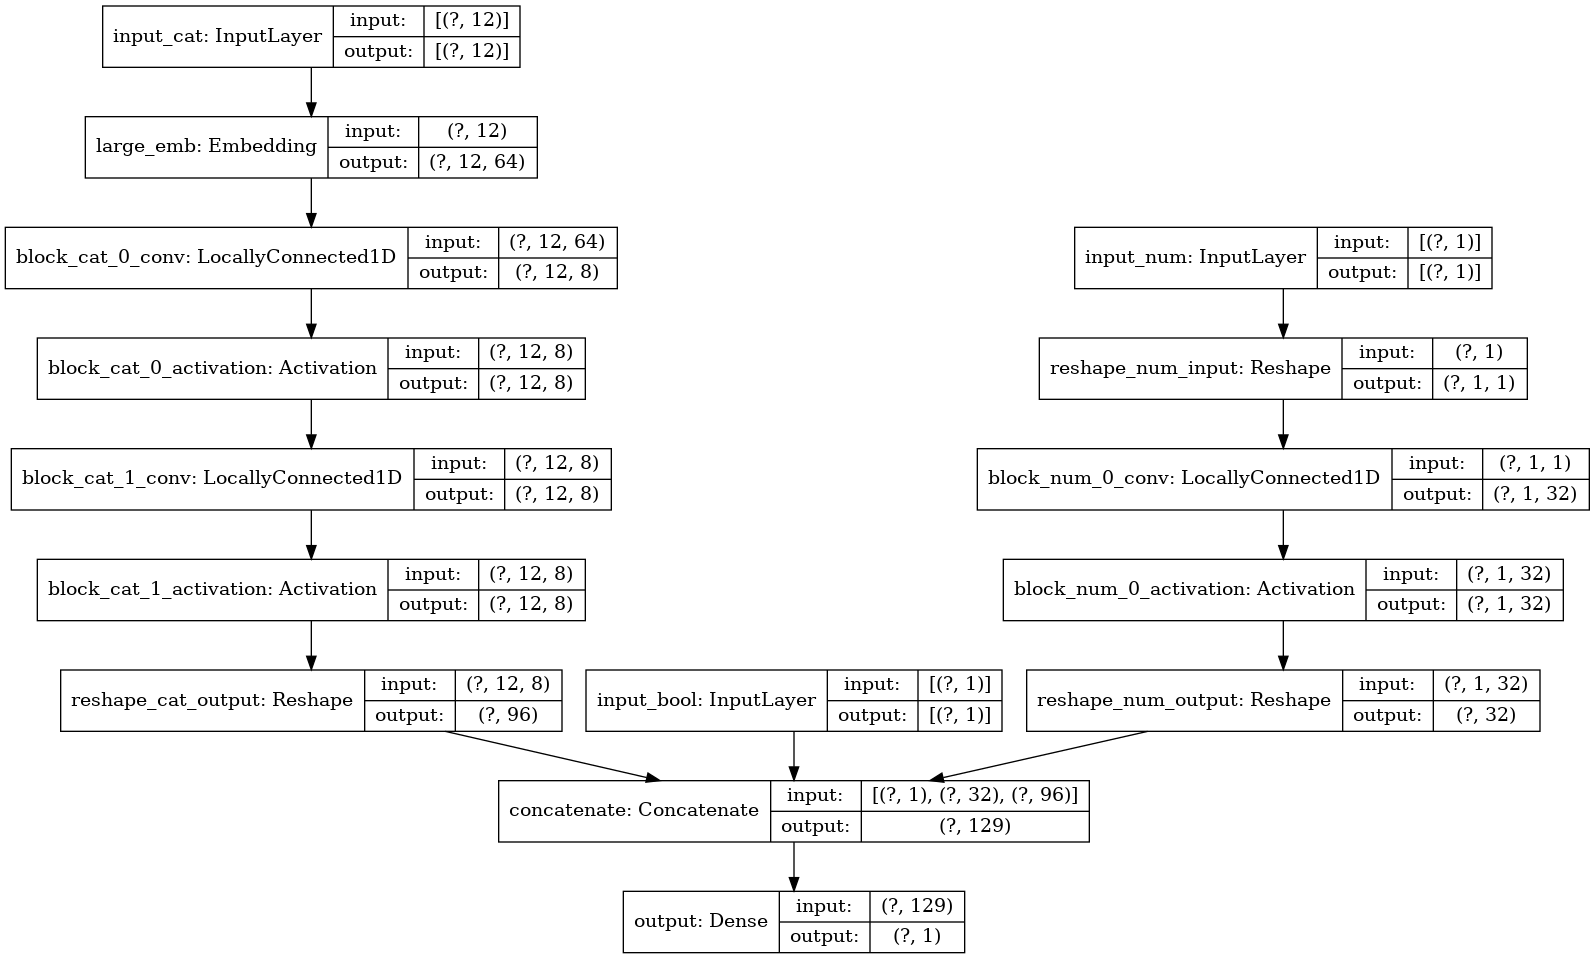

<IPython.core.display.Javascript object>

In [31]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [32]:
y_train.shape

(29304,)

<IPython.core.display.Javascript object>

In [33]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
    class_weight=class_weight
)

Epoch 1/2000
29/29 - 0s - loss: 1.4285 - val_loss: 0.6899
Epoch 2/2000
29/29 - 0s - loss: 1.4263 - val_loss: 0.6895
Epoch 3/2000
29/29 - 0s - loss: 1.4228 - val_loss: 0.6889
Epoch 4/2000
29/29 - 0s - loss: 1.4182 - val_loss: 0.6879
Epoch 5/2000
29/29 - 0s - loss: 1.4118 - val_loss: 0.6862
Epoch 6/2000
29/29 - 0s - loss: 1.4022 - val_loss: 0.6827
Epoch 7/2000
29/29 - 0s - loss: 1.3865 - val_loss: 0.6738
Epoch 8/2000
29/29 - 0s - loss: 1.3601 - val_loss: 0.6592
Epoch 9/2000
29/29 - 0s - loss: 1.3173 - val_loss: 0.6348
Epoch 10/2000
29/29 - 0s - loss: 1.2529 - val_loss: 0.6000
Epoch 11/2000
29/29 - 0s - loss: 1.1678 - val_loss: 0.5556
Epoch 12/2000
29/29 - 0s - loss: 1.0735 - val_loss: 0.5098
Epoch 13/2000
29/29 - 0s - loss: 0.9884 - val_loss: 0.4646
Epoch 14/2000
29/29 - 0s - loss: 0.9237 - val_loss: 0.4402
Epoch 15/2000
29/29 - 0s - loss: 0.8808 - val_loss: 0.4201
Epoch 16/2000
29/29 - 0s - loss: 0.8521 - val_loss: 0.4082
Epoch 17/2000
29/29 - 0s - loss: 0.8310 - val_loss: 0.4006
Epoch 

<IPython.core.display.Javascript object>

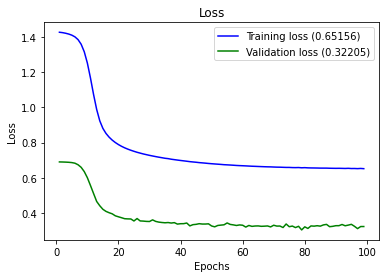

<IPython.core.display.Javascript object>

In [34]:
plot_history(history)

In [35]:
model_auc = roc_auc_score(
    y_true=y_valid,
    y_score=model.predict(input_valid).reshape(-1),
)
model_auc

0.9331659473332398

<IPython.core.display.Javascript object>

In [36]:
model_auc = roc_auc_score(
    y_true=y_test,
    y_score=model.predict(input_test).reshape(-1),
)
model_auc

0.9278894382411936

<IPython.core.display.Javascript object>

In [37]:
# 0.9279080178809533

<IPython.core.display.Javascript object>

In [38]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [39]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [40]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [41]:
y_test.shape

(16280,)

<IPython.core.display.Javascript object>

In [42]:
encoded_output.shape

(16280, 129)

<IPython.core.display.Javascript object>

In [43]:
explanations.shape

(16280, 14)

<IPython.core.display.Javascript object>

In [44]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [45]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['sex', 'fnlwgt', 'hours-per-week', 'education-num',
       'native-country', 'marital-status', 'workclass', 'capital-gain',
       'education', 'relationship', 'age', 'occupation', 'capital-loss',
       'race'], dtype='<U14')

<IPython.core.display.Javascript object>

## Explain global

In [46]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [47]:
global_explain = np.sum(explanations_train, axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

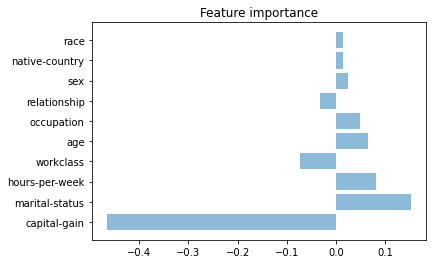

<IPython.core.display.Javascript object>

In [48]:
explain_plot(global_explain, all_cols)

In [49]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / global_explain.sum()

<IPython.core.display.Javascript object>

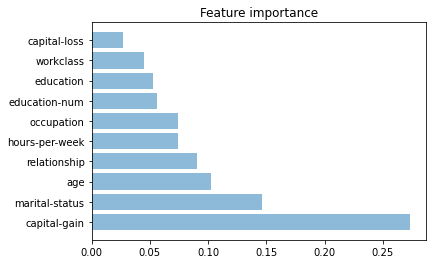

<IPython.core.display.Javascript object>

In [50]:
explain_plot(global_explain, all_cols)

In [51]:
global_explain = np.where(explanations_train >= 0, explanations_train, 0).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

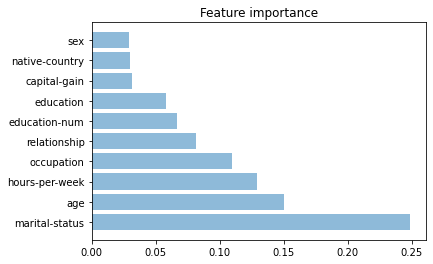

<IPython.core.display.Javascript object>

In [52]:
explain_plot(global_explain, all_cols)

In [53]:
global_explain = np.where(explanations_train < 0, explanations_train, 0).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

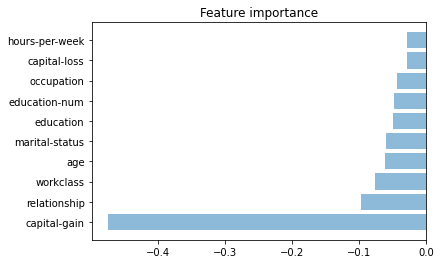

<IPython.core.display.Javascript object>

In [54]:
explain_plot(global_explain, all_cols)

## Explain local

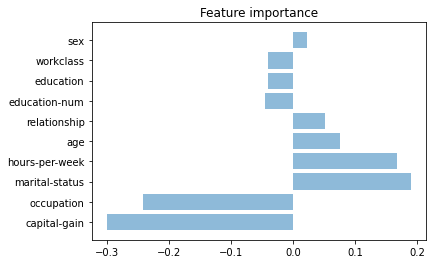

0.39699995517730713


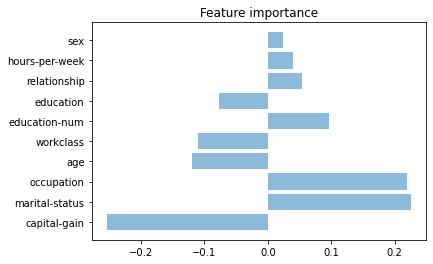

0.5671629309654236


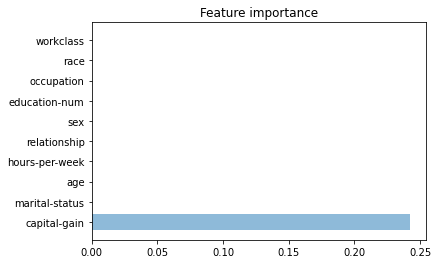

0.9999994039535522


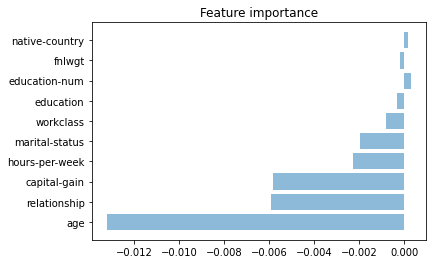

0.002356976270675659


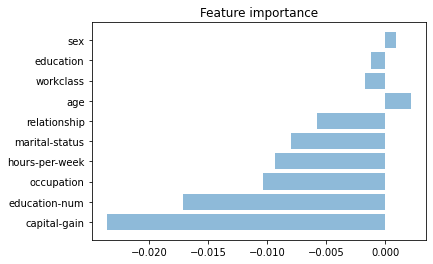

0.009771108627319336


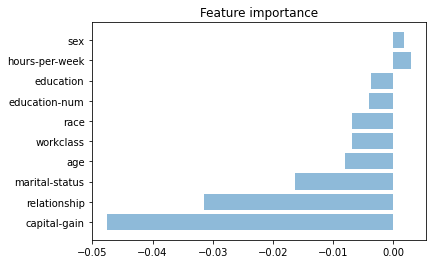

0.020433098077774048


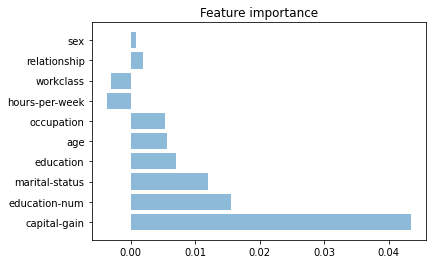

0.992059051990509


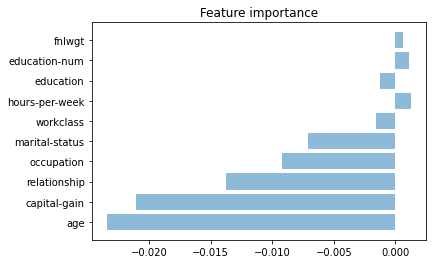

0.00867927074432373


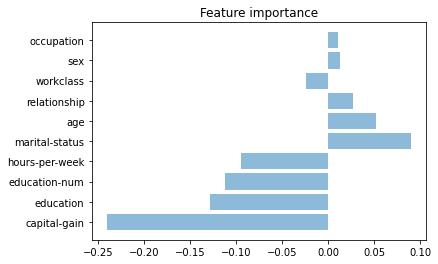

0.1605525016784668


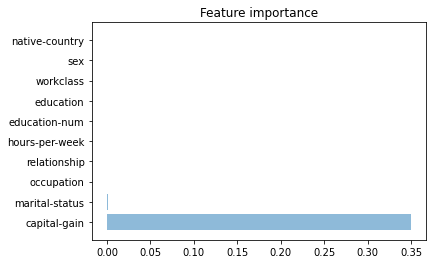

0.9991419315338135


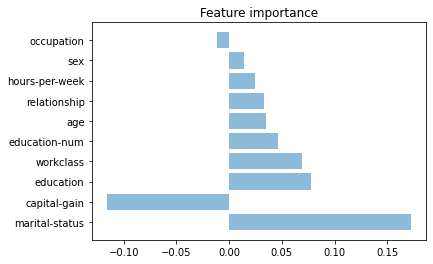

0.8279430866241455


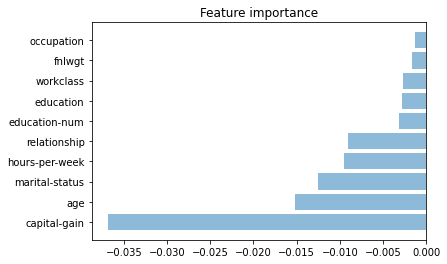

0.015573263168334961


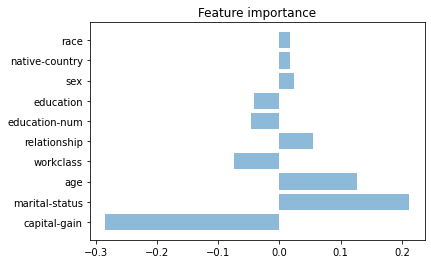

0.47634461522102356


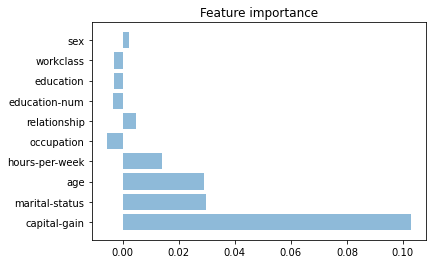

0.9796761274337769


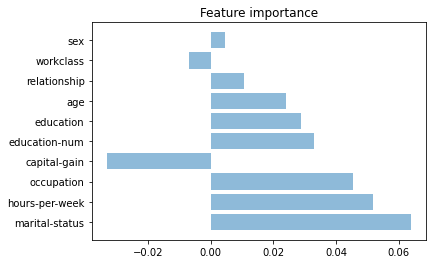

0.9530229568481445


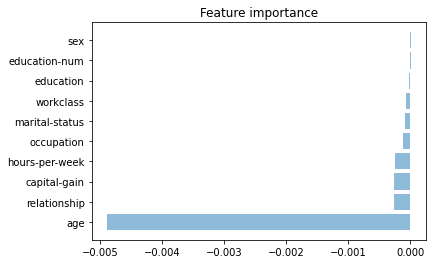

0.00010559213114902377


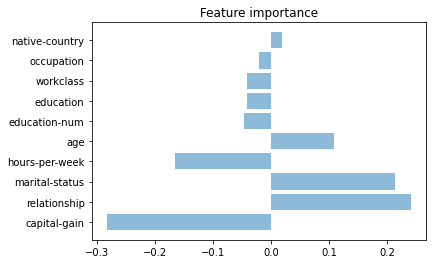

0.4804927110671997


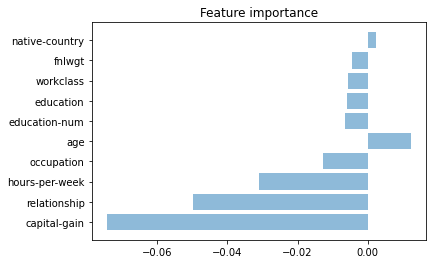

0.033337414264678955


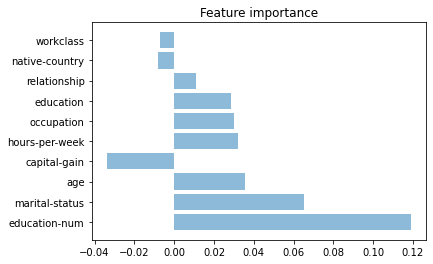

0.9519133567810059


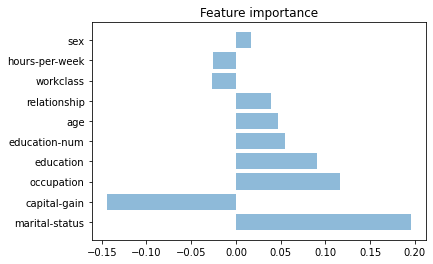

0.7817168831825256


<IPython.core.display.Javascript object>

In [55]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [56]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [57]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([12434,  3846]))

<IPython.core.display.Javascript object>

In [58]:
y_test

array([0, 1, 1, ..., 0, 0, 1])

<IPython.core.display.Javascript object>

In [59]:
target_encoder.classes_

array(['<=50K', '>50K'], dtype=object)

<IPython.core.display.Javascript object>

In [60]:
confusion_matrix(
    y_true=y_test,
    y_pred=model.predict(input_test).reshape(-1) >= 0.5,
    # labels=target_encoder.classes_,
)

array([[10350,  2084],
       [  559,  3287]])

<IPython.core.display.Javascript object>